# FRF_Currituck Sound: Photosynthectically-Active Radiance (PAR) Data

Photic Zone-It extends from the surface down to a depth where light intensity falls to one percent of that at the surface---called the euphotic depth. 

METADATA:
summary: Water quality data Collected at the USACE Coastal Hydraulics Laboratory (CHL), Field Research Facility (FRF) in Duck, NC. These data were collected in the Currituck Sound with a WetLabs ECO PARS photosynthetically active radiation sensor. Data were sampled every 300 sec. Sensor samples 80 samples at 2 Hz and results are average. This sensor has a copper faceplate and a mechanical copper wiper to prevent biofouling.

geospatial_vertical_units: m
geospatial_vertical_resolution: 0.0
geospatial_vertical_min: -4.0
geospatial_vertical_max: 4.0
geospatial_vertical_origin: NAVD88
geospatial_vertical_positive: up
geospatial_lat_min: 36.258436
geospatial_lat_max: 36.258436
geospatial_lat_units: degrees_north
geospatial_lon_min: -75.847719
geospatial_lon_max: -75.847719
geospatial_lon_units: degrees_east

top sensor_nomDepth: 1.0 meters
bottom sensor nomDepth: 1.5 meters

- Station: CS01, nom water depth: 3.4 m
- Station: CS02, nom water depth:
- Station: CS03, nom water depth: 2.3 m
- Station: CS04, nom water depth:
- Station: CS05, nom water depth:

The data: https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/oceanography/waterquality/


python netcdf4 documentation: http://unidata.github.io/netcdf4-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
import time
import datetime

%matplotlib inline

### Load the PAR data for stations 1, 2, and 3 into pandas dataframes, one dataframe per station:

In [2]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/'

## load and runs script to retrieve ECOPAR data from FRF Thredds server (Because the script
## writes the retrived data to a csv file, you should not have to run this script more
## than once. Subsequent runs of this notebook should only require that you reload the
## data fr the csv file to a dataframe called df...)

#%run ./scripts/Load_FRF_CurrituckSnd_Station_Data_PAR.py

## load data from existing csv file into a new dataframe:
df=pd.read_csv(data_path+'ECOPAR_Data_ALL.csv', na_values=-999.99).dropna(subset=['PAR'])

## Set date time values to Python datetime types, On UT coordinated...
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.round('1s')
df.drop(['index','year','month'], axis=1, inplace=True)
df.set_index('datetime', drop=False, inplace=True )

df.describe()

,PAR
count,909772.000000
mean,34.310092
std,79.018416
min,0.039365
25%,0.040000
50%,0.251625
75%,27.778187
max,2970.655762


### Is a PAR max of >2970 um/m^2 s unreasonably high?

I don't know...

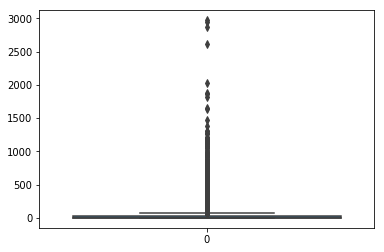

In [3]:
sns.boxplot(data=df['PAR'])

### Split df into 6 separate dataframes by station (CS01, 02, and 03) and by sensor position (i.e., top, bot)

In [4]:
df_CS01T = df.query('station == \'CS01\' & sensor == \'top\'').drop(['station', 'sensor'], axis=1)
df_CS02T = df.query('station  ==\'CS02\' & sensor == \'top\'').drop(['station', 'sensor'], axis=1)
df_CS03T = df.query('station == \'CS03\' & sensor == \'top\'').drop(['station', 'sensor'], axis=1)

df_CS01B = df.query('station == \'CS01\' & sensor == \'bot\'').drop(['station', 'sensor'], axis=1)
df_CS02B = df.query('station  ==\'CS02\' & sensor == \'bot\'').drop(['station', 'sensor'], axis=1)
df_CS03B = df.query('station == \'CS03\' & sensor == \'bot\'').drop(['station', 'sensor'], axis=1)

In [5]:
df_CS03T.head()

,datetime,PAR
datetime,,
2016-04-28 17:35:06+00:00,2016-04-28 17:35:06+00:00,81.917999
2016-04-28 17:40:05+00:00,2016-04-28 17:40:05+00:00,56.000000
2016-04-28 17:45:05+00:00,2016-04-28 17:45:05+00:00,25.620001
2016-04-28 17:50:06+00:00,2016-04-28 17:50:06+00:00,29.375000
2016-04-28 17:55:06+00:00,2016-04-28 17:55:06+00:00,32.736000


### Set station/position dataframe indices to datetime field and then aggregate PAR data to one record/observation per day

In [6]:
df_CS01T=df_CS01T.resample('D').mean().copy()

df_CS02T=df_CS02T.resample('D').mean().copy()

df_CS03T=df_CS03T.resample('D').mean().copy()

df_CS01B=df_CS01B.resample('D').mean().copy()

df_CS02B=df_CS02B.resample('D').mean().copy()

df_CS03B=df_CS03B.resample('D').mean().copy()

### Rename PAR variables in each of the PAR dataframes to reflect their respective sensor positions in the water column...

that is, rename the PAR var in df_CS03T to PAR_top and rename the PAR var in df_CS03B to PAR_bot

In [7]:
df_CS01T['PAR_top']=df_CS01T['PAR']
df_CS02T['PAR_top']=df_CS02T['PAR']
df_CS03T['PAR_top']=df_CS03T['PAR']

df_CS01B['PAR_bot']=df_CS01B['PAR']
df_CS02B['PAR_bot']=df_CS02B['PAR']
df_CS03B['PAR_bot']=df_CS03B['PAR']

### Drop the old existing PAR variable from each dataframe

it's redundant with the newly added, and soon to be more useful, PAR_top/bot

In [8]:
df_CS01T.drop(['PAR'], axis=1, inplace=True)
df_CS02T.drop(['PAR'], axis=1, inplace=True)
df_CS03T.drop(['PAR'], axis=1, inplace=True)

df_CS01B.drop(['PAR'], axis=1, inplace=True)
df_CS02B.drop(['PAR'], axis=1, inplace=True)
df_CS03B.drop(['PAR'], axis=1, inplace=True)

### Plot the PARs for Stations 1, 2, and 3

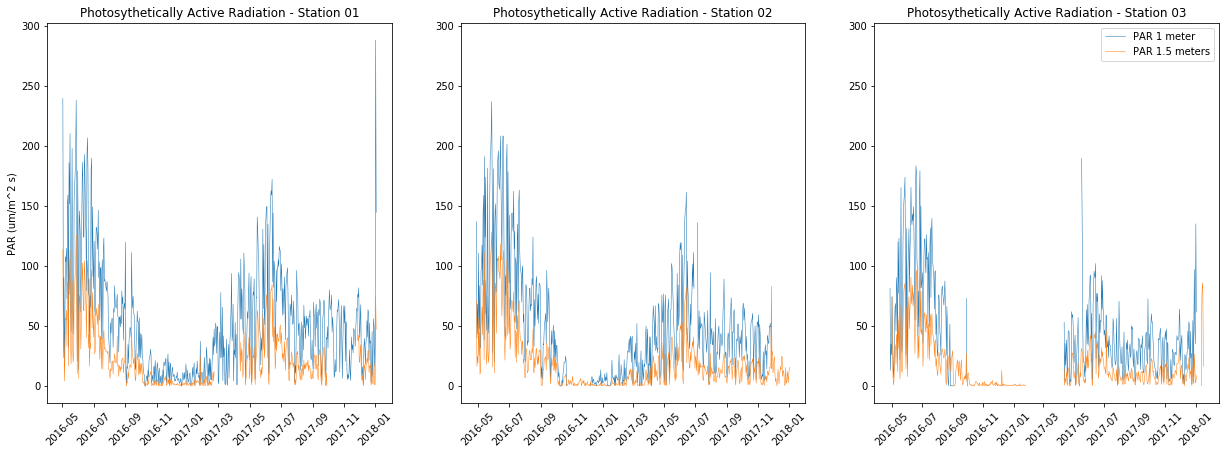

In [18]:
fig1 = plt.figure(figsize=(21,7))

ax11=fig1.add_subplot(131)
ax11.plot(df_CS01T.index, df_CS01T.PAR_top, linewidth=0.5, label='PAR 1 meter')
ax11.plot(df_CS01B.index, df_CS01B.PAR_bot, linewidth=0.5, label='PAR 1.5 meters')
ax11.tick_params(axis='x', rotation=45)
ax11.set_ylabel('PAR (um/m^2 s)')
ax11.set_title('Photosythetically Active Radiation - Station 01')

ax12=fig1.add_subplot(132, sharey=ax11)
ax12.plot(df_CS02T.index, df_CS02T.PAR_top, linewidth=0.5, label='PAR 1 meter')
ax12.plot(df_CS02B.index, df_CS02B.PAR_bot, linewidth=0.5, label='PAR 1.5 meters')
ax12.tick_params(axis='x', rotation=45)
ax12.set_title('Photosythetically Active Radiation - Station 02')

ax13=fig1.add_subplot(133, sharey=ax11)
ax13.plot(df_CS03T.index, df_CS03T.PAR_top, linewidth=0.5, label='PAR 1 meter')
ax13.plot(df_CS03B.index, df_CS03B.PAR_bot, linewidth=0.5, label='PAR 1.5 meters')
ax13.tick_params(axis='x', rotation=45)
ax13.set_title('Photosythetically Active Radiation - Station 03')

plt.legend()

### Load Water Quality, Wave, and Currents data for Stations 01 and 02

Stations 1 and 2 share single turbidity and chlorophyll measures, versus the upper and lower water column sampling at station 3. Station 3 measures turbidity, along with PAR, at two levels in the water column. We'll look at the comparisons at station 3 next.

NOTE that stations 1 and 2 measure turbidity in FNUs. Stations 3, 4, and 5 record this same metric in NTUs. Does this make any difference in comparing one versus the other versus the other? I don't know...

In [10]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/'

## load the water quality and waves data for stations 01 and 02 and ready them for plotting against the PAR metrics
stations=['CS01', 'CS02']
EXO_data_files=['/FRF_CS01-EXO_ALL.csv', '/FRF_CS02-EXO_ALL.csv']
wave_data_files=['/FRF_CS01-SBE26_Waves_ALL.csv', '/FRF_CS02-SBE26_Waves_ALL.csv']
current_data_files=['/FRF_CS01-ADOP_Currents_ALL.csv', '/FRF_CS02-ADOP_Currents_ALL.csv']

dfQ=pd.DataFrame()   ## water quality data
dfW=pd.DataFrame()   ## surface wave data
dfC=pd.DataFrame()   ## water column currents data

# load water_quality data:
for file, station in zip(EXO_data_files, stations):
    df_=pd.read_csv(data_path+station+file, na_values=-999.99)
    df_['station']=station
    df_['datetime'] = pd.to_datetime(df_['datetime'], utc=True).dt.round('1s')
    dfQ=dfQ.append(df_)

# load wave data:
for file, station in zip(wave_data_files, stations):
    df_=pd.read_csv(data_path+station+file, na_values=-999.99)
    df_['station']=station
    df_['datetime'] = pd.to_datetime(df_['datetime'], utc=True).dt.round('1s')
    dfW=dfW.append(df_)

# load current data:
for file, station in zip(current_data_files, stations):
    df_=pd.read_csv(data_path+station+file, na_values=-999.99)
    df_['station']=station
    df_['datetime'] = pd.to_datetime(df_['datetime'], utc=True).dt.round('1s')
    dfC=dfC.append(df_)

### Parse water quality, waves, and currents dataframes by station (CS01 and CS02)

Again, we'll deal with station CS03 later...

In [11]:
## create the new extract dataframes., one per station per theme:
WQ01=dfQ.query('station == \'CS01\'').drop(['station'], axis=1)
WV01=dfW.query('station == \'CS01\'').drop(['station'], axis=1)
CU01=dfC.query('station == \'CS01\'').drop(['station'], axis=1)

WQ02=dfQ.query('station == \'CS02\'').drop(['station'], axis=1)
WV02=dfW.query('station == \'CS02\'').drop(['station'], axis=1)
CU02=dfC.query('station == \'CS02\'').drop(['station'], axis=1)

## set index for each new extract dataframe to the datetime field:
WQ01.set_index('datetime', drop=True, inplace=True)
WV01.set_index('datetime', drop=True, inplace=True)
CU01.set_index('datetime', drop=True, inplace=True)

WQ02.set_index('datetime', drop=True, inplace=True)
WV02.set_index('datetime', drop=True, inplace=True)
CU02.set_index('datetime', drop=True, inplace=True)

## Remove single OUTLIER value for turbidity (464.xx NTU) seen at Station 01:
WQ01=WQ01.loc[WQ01['turbidity'] < 400.0]

## resample each extract dataframe, averaging PAR by day:
WQ01=WQ01.resample('D').mean().copy()
WV01=WV01.resample('D').mean().copy()
CU01=CU01.resample('D').mean().copy()

WQ02=WQ02.resample('D').mean().copy()
WV02=WV02.resample('D').mean().copy()
CU02=CU02.resample('D').mean().copy()

In [12]:
WQ01.head()

,water_temp,salinity,pH,turbidity,chlorophyll,DOsat,DOmass,gaugeDepth,blueGreenAlgae,fDOM
datetime,,,,,,,,,,
2016-02-17 00:00:00+00:00,5.607667,1.776667,7.712667,16.070583,12.874333,103.823083,12.902000,1.359036,21.910583,102.486750
2016-02-18 00:00:00+00:00,5.327336,1.816135,7.660149,36.286202,13.717460,102.067242,12.770916,1.308103,24.295774,93.143350
2016-02-19 00:00:00+00:00,5.195400,2.095749,7.695003,29.710143,13.756655,100.948918,12.649843,1.232463,25.377797,88.468007
2016-02-20 00:00:00+00:00,5.895704,1.674918,7.700201,18.203874,13.479921,103.474658,12.773091,1.351801,22.341273,108.724303
2016-02-21 00:00:00+00:00,6.949512,1.545014,7.738365,14.034340,13.893830,105.322272,12.671692,1.381187,22.972148,116.959951


### Plot PAR versus turbidity, chlorophyll, and significant wave heights at each station (CS01 and CS02):

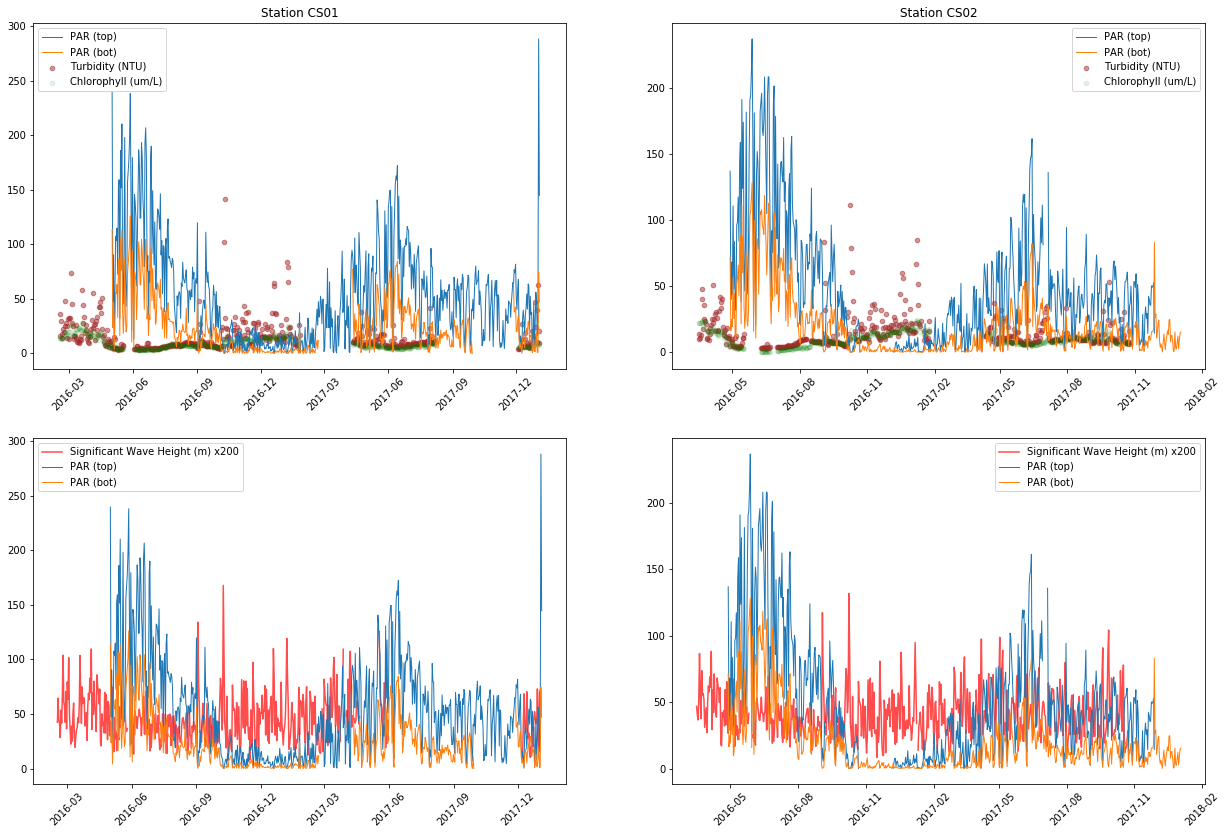

In [19]:
fig3=plt.figure(figsize=(21,14))
fig3.tight_layout()

## for Station CS01:
ax121=fig3.add_subplot(2,2,1)
ax121.scatter(WQ01.index, WQ01['turbidity'], s=21, alpha=0.5, c='brown', label='Turbidity (NTU)')
ax121.scatter(WQ01.index, WQ01['chlorophyll'], s=21, alpha=0.1, c='green', label='Chlorophyll (um/L)')
ax121.plot(df_CS01T.index, df_CS01T['PAR_top'], linewidth=1, label='PAR (top)')
ax121.plot(df_CS01B.index, df_CS01B['PAR_bot'], linewidth=1, label='PAR (bot)')
ax121.tick_params(axis='x', rotation=45)
#ax121.set_ylabel('PAR (um/m^2 s)')
ax121.set_title('Station CS01')
ax121.legend()
#plt.savefig('CS01_PAR_CHL_Turb.pdf', bbox_inches='tight')

ax223=fig3.add_subplot(2,2,3)
ax223.plot(WV01.index, WV01['waveHs']*200,  alpha=0.7, c='red', label='Significant Wave Height (m) x200')
ax223.plot(df_CS01T.index, df_CS01T['PAR_top'], linewidth=1, label='PAR (top)')
ax223.plot(df_CS01B.index, df_CS01B['PAR_bot'], linewidth=1, label='PAR (bot)')
ax223.tick_params(axis='x', rotation=45)
#ax223.set_ylabel('Significant Wave Height (m)')
ax223.legend()
#plt.savefig('CS)!_PAR_Hs.pdf', bbox_inches='tight')

## for Station CS02:
ax222=fig3.add_subplot(2,2,2)
ax222.scatter(WQ02.index, WQ02['turbidity'], s=21, alpha=0.5, c='brown', label='Turbidity (NTU)')
ax222.scatter(WQ02.index, WQ02['chlorophyll'], s=21, alpha=0.1, c='green', label='Chlorophyll (um/L)')
ax222.plot(df_CS02T.index, df_CS02T['PAR_top'], linewidth=1, label='PAR (top)')
ax222.plot(df_CS02B.index, df_CS02B['PAR_bot'], linewidth=1, label='PAR (bot)')
ax222.tick_params(axis='x', rotation=45)
#ax222.set_ylabel('PAR (um/m^2 s)')
ax222.set_title('Station CS02')
ax222.legend()


ax224=fig3.add_subplot(2,2,4)
ax224.plot(WV02.index, WV02['waveHs']*200,  alpha=0.7, c='red', label='Significant Wave Height (m) x200')
ax224.plot(df_CS02T.index, df_CS02T['PAR_top'], linewidth=1, label='PAR (top)')
ax224.plot(df_CS02B.index, df_CS02B['PAR_bot'], linewidth=1, label='PAR (bot)')
ax224.tick_params(axis='x', rotation=45)
ax224.legend()

### Correlation Matrix: Stations 01 and 02

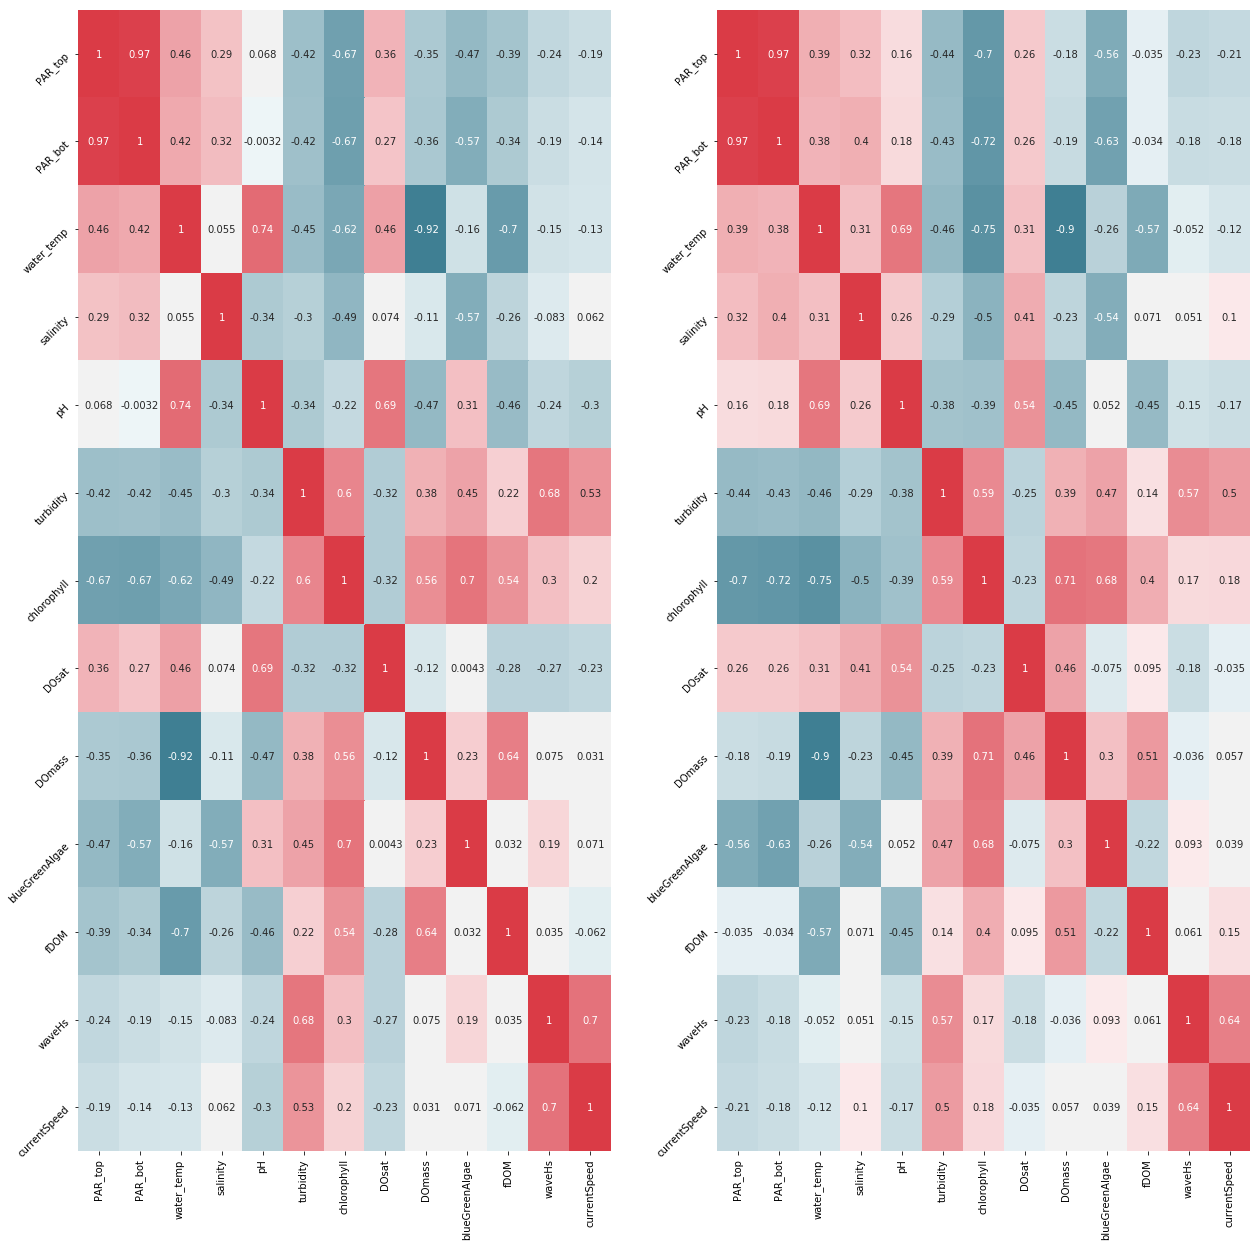

In [133]:
fig4=plt.figure(figsize=(21,21) )

WQVT01 = pd.concat([df_CS01T,df_CS01B,WQ01,WV01,CU01], axis=1,  sort=False)   #ignore_index=True,
WQVT02 = pd.concat([df_CS02T,df_CS02B,WQ02,WV02,CU02], axis=1,  sort=False)
          
cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)

ax41=fig4.add_subplot(121)
sns.heatmap(WQVT01[['PAR_top','PAR_bot','water_temp','salinity','pH','turbidity','chlorophyll','DOsat','DOmass','blueGreenAlgae',
                   'fDOM','waveHs', 'currentSpeed']].corr(), annot=True, cmap=cmap, cbar=False, ax=ax41 )  ## concatenate two (or three) station data frames...
ax41.tick_params(axis='y', rotation=45)

ax42=fig4.add_subplot(122)
sns.heatmap(WQVT02[['PAR_top','PAR_bot','water_temp','salinity','pH','turbidity','chlorophyll','DOsat','DOmass','blueGreenAlgae',
                   'fDOM','waveHs', 'currentSpeed']].corr(), annot=True, cmap=cmap, cbar=False, ax=ax42 )  ## concatenate two (or three) station data frames...
ax42.tick_params(axis='y', rotation=45)

In [ ]:
dfQ.query('station == \'CS02\'')

In [ ]:
s='CS05-DuoCT/CS05-DuoCT.ncml'
s.split('/')[1]

<h3>For Station 3...</h3>

### Load Water Quality, Wave, and Currents data for Station 03

Unlike stations 1 and 2 which share single turbidity (NTU) and chlorophyll (ug/L) measures with a pair of PAR (umol/m^2 sec) measures, station 3 adds an additional turbidity measurement in the water column in accord with a pair of PARs. Let's have a look...


Notes:
1.) Nominal water depth at Station 3: 2.3 meters <br>
2.) DTS sensor used to capture turbidity at two levels in water column:  <br>
    - top sensor_nomDepth: 1.33 m
    - bottom sensorHeightAboveBottom: 0.165 m
3.) CS03-DTS12-bot/CS03-DTS12-bot.ncml data for 2016 only <br>
4.) CS03-DTS12-top/CS03-DTS12-top.ncml data for 2016, 2017, and 2018 <br>
5.) EcoPAR sensor SN 481 used to measure Photosynthetically Active Radiation at two levels <br>
    - top sensor is at 1 m water depth and is exactly 0.5 meters above ECO PARS SN 483
    - bottom sensor is at 1.5 m water depth and is exactly 0.5 m below ECO PARS SN 481
   

In [13]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/CS03/'
CT_data='FRF_CS03-Microcat.csv'
Turb_top='FRF_CS03-DTS12-top.csv'
Turb_bot='FRF_CS03-DTS12-bot.csv'
wave_data='FRF_CS03-SBE26_Waves_ALL.csv'
current_data='FRF_CS03-ADOP_Currents_ALL.csv'

## Load the data into pandas dataframes:
df_ct=pd.read_csv(data_path+CT_data, na_values=-999.990)
df_t_top=pd.read_csv(data_path+Turb_top, na_values=-999.990)
df_t_bot=pd.read_csv(data_path+Turb_bot, na_values=-999.990)
df_wav=pd.read_csv(data_path+wave_data, na_values=-999.990)
df_cur=pd.read_csv(data_path+current_data, na_values=-999.990)

#df_cur.info()       ## use to check data size, types, and missing values. Uncomment to run...
#df_wav.isnull().sum() ## ditto the check above

## Set date time values to Python datetime types, On UT coordinated...
df_ct['datetime'] = pd.to_datetime(df_ct['datetime'], utc=True).dt.round('1s')
df_t_top['datetime'] = pd.to_datetime(df_t_top['datetime'], utc=True).dt.round('1s')
df_t_bot['datetime'] = pd.to_datetime(df_t_bot['datetime'], utc=True).dt.round('1s')
df_wav['datetime'] = pd.to_datetime(df_wav['datetime'], utc=True).dt.round('1s')
df_cur['datetime'] = pd.to_datetime(df_cur['datetime'], utc=True).dt.round('1s')

## Assign datetime field to data frame index
df_ct.set_index('datetime', inplace=True)
df_t_top.set_index('datetime', inplace=True)
df_t_bot.set_index('datetime', inplace=True)
df_wav.set_index('datetime', inplace=True)
df_cur.set_index('datetime', inplace=True)

## Join the 3 separate dataframes into a single df (makes life easier, I hope...)
WQ03=pd.concat([df_ct, df_t_top, df_t_bot, df_wav, df_cur,df_CS03T,df_CS03B], axis=1)
WQ03=WQ03.resample('D').mean().copy()

In [24]:
WQ03.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 690 entries, 2016-02-27 to 2018-01-16
Freq: D
Data columns (total 14 columns):
water_temp           638 non-null float64
salinity             636 non-null float64
turbidity_upper      611 non-null float64
turbidity_lower      212 non-null float64
depth                315 non-null float64
waveHs               314 non-null float64
wavePeakFrequency    318 non-null float64
aveE                 45 non-null float64
aveN                 45 non-null float64
currentDirection     45 non-null float64
currentSpeed         45 non-null float64
meanPressure         45 non-null float64
PAR_top              394 non-null float64
PAR_bot              540 non-null float64
dtypes: float64(14)
memory usage: 80.9 KB


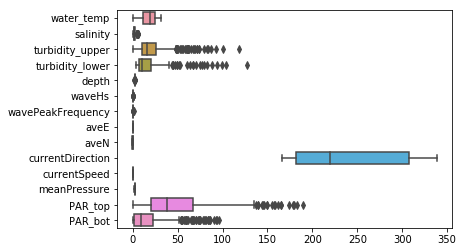

In [26]:
sns.boxplot(data=WQ03, orient='h')

### Station 3 Plots:

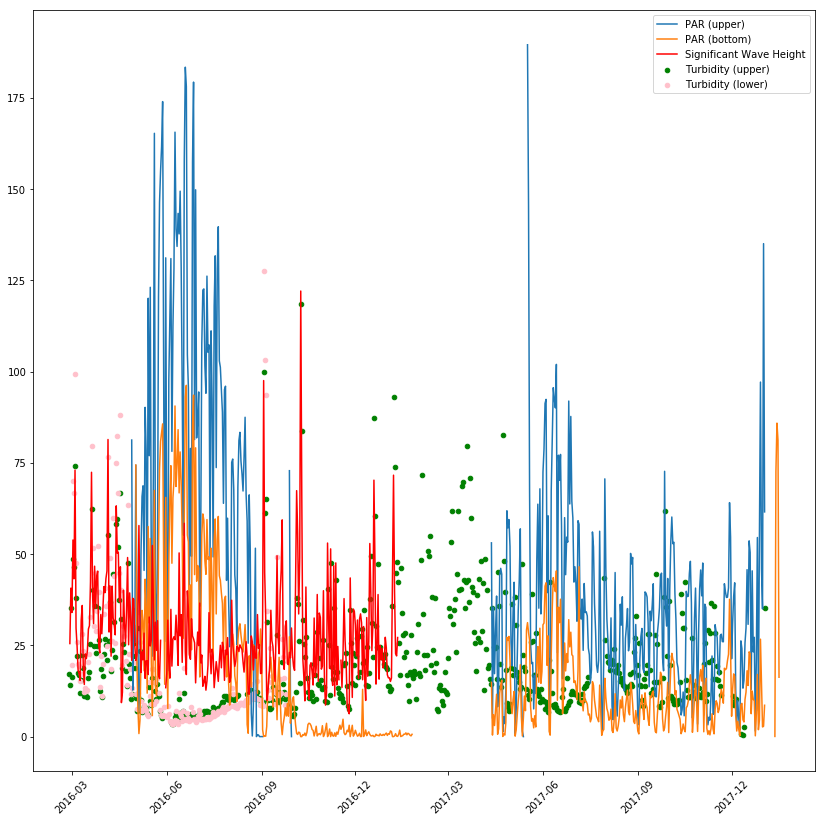

In [79]:
#WQ03.info() 
fig5=plt.figure(figsize=(14, 14))
ax51=fig5.add_subplot(1,1,1)
ax51.scatter(WQ03.index, WQ03['turbidity_upper'], s=21, c='green', label='Turbidity (upper)')
ax51.scatter(WQ03.index, WQ03['turbidity_lower'], s=21, c='pink', label='Turbidity (lower)')
ax51.plot(WQ03.index, WQ03['PAR_top'], label='PAR (upper)')
ax51.plot(WQ03.index, WQ03['PAR_bot'], label='PAR (bottom)')
ax51.plot(WQ03.index, WQ03['waveHs']*200, c='red', label='Significant Wave Height')
ax51.tick_params(axis='x', rotation=45)
ax51.legend()

### Station 3 Correlation Matrix

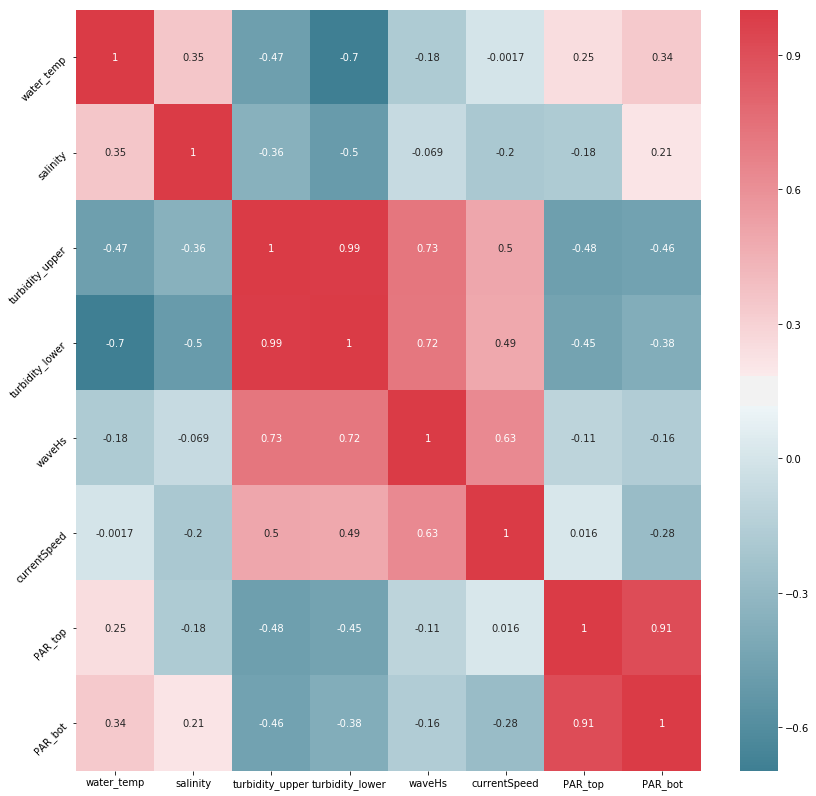

In [93]:
fig6=plt.figure(figsize=(14,14))

cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
sns.heatmap(WQ03[['water_temp','salinity','turbidity_upper','turbidity_lower','waveHs','currentSpeed',
                  'PAR_top','PAR_bot']].corr(), annot=True, cmap=cmap, ax=fig6.add_subplot(111) )  ## concatenate two (or three) station data frames...
plt.tick_params(axis='y', rotation=45)
#

### Station 3: Mixed Plots:

(-5, 200)

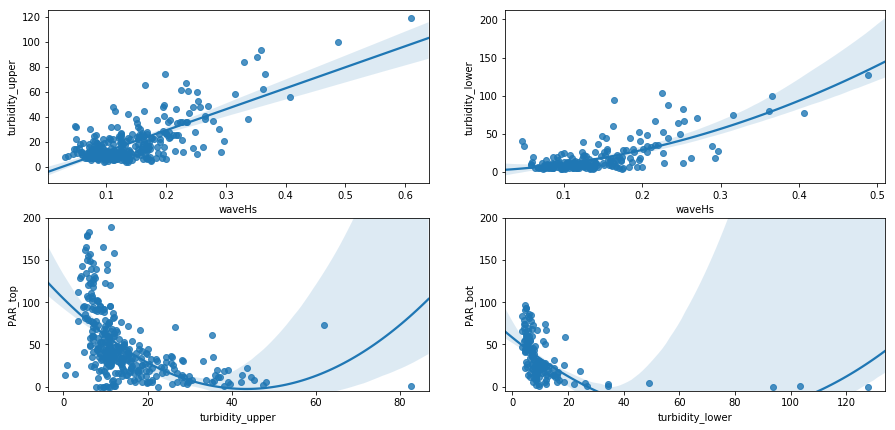

In [54]:
fig7=plt.figure(figsize=(15,7))

ax71=fig7.add_subplot(2,2,1)
sns.regplot(x='waveHs', y='turbidity_upper', data=WQ03, order=1, ax=ax71)

ax72=fig7.add_subplot(2,2,2)
sns.regplot(x='waveHs', y='turbidity_lower', data=WQ03, order=2, ax=ax72)

ax73=fig7.add_subplot(2,2,3)
sns.regplot(x='turbidity_upper', y='PAR_top', data=WQ03, order=2, fit_reg=True, ax=ax73)
ax73.set_ylim(-5,200)

ax74=fig7.add_subplot(2,2,4)
sns.regplot(x='turbidity_lower', y='PAR_bot', data=WQ03, order=2, ax=ax74)
ax74.set_ylim(-5,200)

<h3>Station 4:</h3>

### Load Water Quality (turbidity only in this instance), Waves, and Currents Data for Station 4

In [14]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/CS04/'
Turb_top='FRF_CS04-DTS12-top.csv'
Turb_bot='FRF_CS04-DTS12-bot.csv'
wave_data='FRF_CS04-SBE26_Waves_ALL.csv'
current_data='FRF_CS04-ADOP_Currents_ALL.csv'

## Load the data into pandas dataframes:
df_t_top=pd.read_csv(data_path+Turb_top, na_values=-999.990)
df_t_bot=pd.read_csv(data_path+Turb_bot, na_values=-999.990)
df_wav=pd.read_csv(data_path+wave_data, na_values=-999.990)
df_cur=pd.read_csv(data_path+current_data, na_values=-999.990)

## Set date time values to Python datetime types, On UT coordinated...
df_t_top['datetime'] = pd.to_datetime(df_t_top['datetime'], utc=True).dt.round('1s')
df_t_bot['datetime'] = pd.to_datetime(df_t_bot['datetime'], utc=True).dt.round('1s')
df_wav['datetime'] = pd.to_datetime(df_wav['datetime'], utc=True).dt.round('1s')
df_cur['datetime'] = pd.to_datetime(df_cur['datetime'], utc=True).dt.round('1s')

## Assign datetime field to data frame index
df_t_top.set_index('datetime', inplace=True)
df_t_bot.set_index('datetime', inplace=True)
df_wav.set_index('datetime', inplace=True)
df_cur.set_index('datetime', inplace=True)

## Join the 3 separate dataframes into a single df (makes life easier, I hope...)
WQ04=pd.concat([df_t_top, df_t_bot, df_wav, df_cur], axis=1)
WQ04=WQ04.resample('D').mean().copy()

In [15]:
WQ04.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 710 entries, 2016-02-02 to 2018-01-11
Freq: D
Data columns (total 10 columns):
turbidity_upper      710 non-null float64
turbidity_lower      180 non-null float64
depth                703 non-null float64
waveHs               695 non-null float64
wavePeakFrequency    699 non-null float64
aveE                 487 non-null float64
aveN                 487 non-null float64
currentDirection     487 non-null float64
currentSpeed         487 non-null float64
meanPressure         487 non-null float64
dtypes: float64(10)
memory usage: 61.0 KB


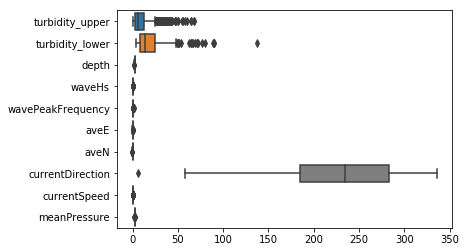

In [6]:
sns.boxplot(data=WQ04, orient='h')

### Station 4 Plots:

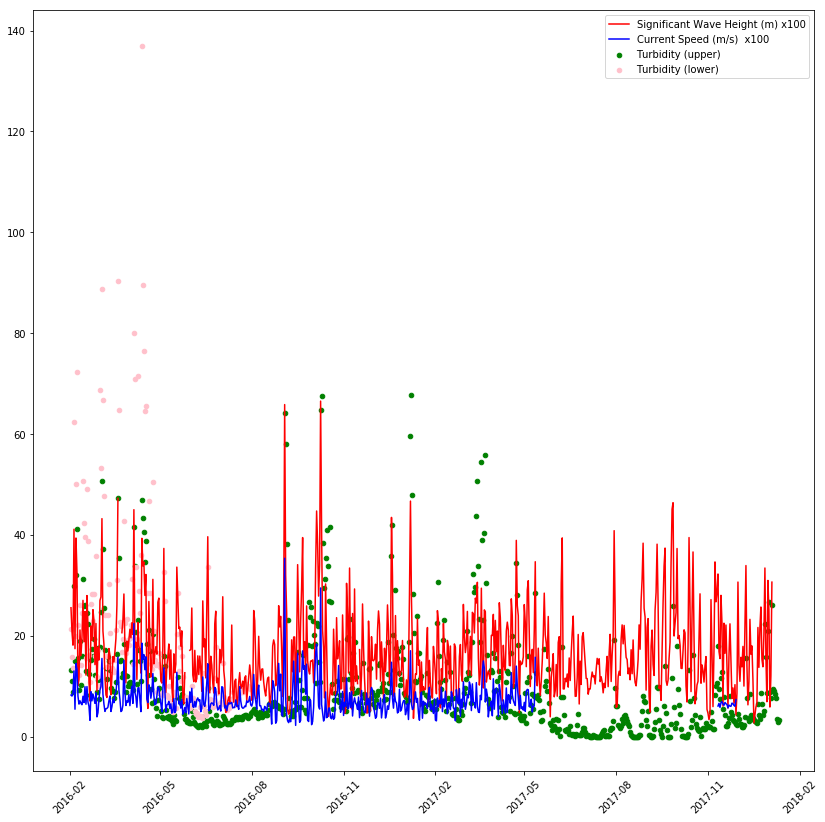

In [30]:
fig8=plt.figure(figsize=(14, 14))
ax81=fig8.add_subplot(1,1,1)
ax81.scatter(WQ04.index, WQ04['turbidity_upper'], s=21, c='green', label='Turbidity (upper)')
ax81.scatter(WQ04.index, WQ04['turbidity_lower'], s=21, c='pink', label='Turbidity (lower)')
ax81.plot(WQ04.index, WQ04['waveHs']*100, c='red', label='Significant Wave Height (m) x100')
ax81.plot(WQ04.index, WQ04['currentSpeed']*100, c='blue', label='Current Speed (m/s)  x100')
ax81.tick_params(axis='x', rotation=45)
ax81.legend()

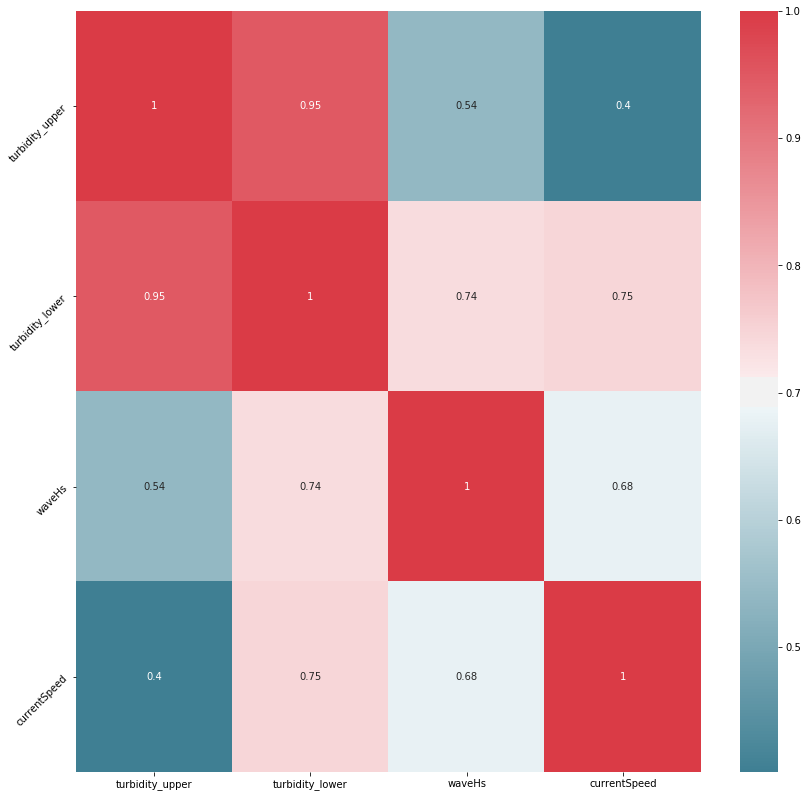

In [39]:
fig9=plt.figure(figsize=(14,14))

cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
sns.heatmap(WQ04[['turbidity_upper','turbidity_lower','waveHs','currentSpeed',]].corr(), 
            annot=True, cmap=cmap, ax=fig9.add_subplot(111) )  ## concatenate two (or three) station data frames...
plt.tick_params(axis='y', rotation=45)

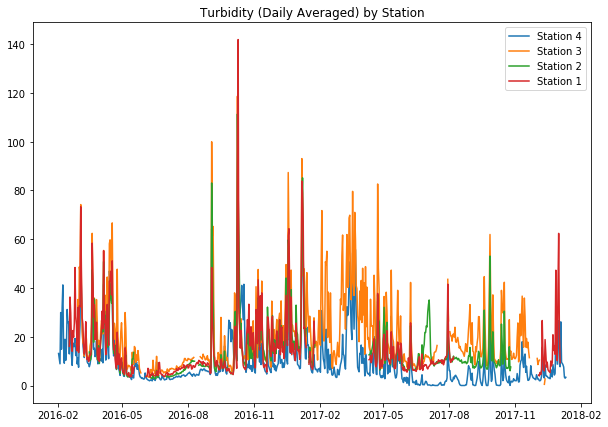

In [16]:
fig10=plt.figure(figsize=(10,7))
ax101=fig10.add_subplot(1,1,1)

ax101.plot(WQ04.index, WQ04['turbidity_upper'], label='Station 4')
ax101.plot(WQ03.index, WQ03['turbidity_upper'], label='Station 3')
ax101.plot(WQ02.index, WQ02['turbidity'], label='Station 2')
ax101.plot(WQ01.index, WQ01['turbidity'], label='Station 1')
ax101.set_title('Turbidity (Daily Averaged) by Station')
ax101.legend()

### Vertical Diffuse Attenuation Coefficient for Downwelling Photosynthetic Radiance (Kd):

In [28]:
## Equation for computing Kd from discrete PAR data:

z1=1.0
z2=1.5
Edz1=df_CS01T.loc['2017-12-14':'2017-12-15'].PAR_top
Edz2=df_CS01B.loc['2017-12-14':'2017-12-15'].PAR_bot

print( (1/z2-z1)*(np.log(Edz1/Edz2)) )

datetime
2017-12-14 00:00:00+00:00   -0.295270
2017-12-15 00:00:00+00:00   -0.267611
Freq: D, dtype: float64


In [30]:
! curl https://chlthredds.erdc.dren.mil/thredds/dodsC/frf/oceanography/waterquality/CS01-Kd/2017/FRF-ocean_waterquality_CS01-Kd_201712.nc

curl: (60) SSL certificate problem: unable to get local issuer certificate
More details here: https://curl.haxx.se/docs/sslcerts.html

curl failed to verify the legitimacy of the server and therefore could not
establish a secure connection to it. To learn more about this situation and
how to fix it, please visit the web page mentioned above.
